# Example 4: HKR multiclass and fooling

This notebook will show how to train a Lispchitz network in a multiclass configuration.
The HKR (hinge-Kantorovich-Rubinstein) loss is extended to multiclass using a one-vs all
setup. The notebook will go through the process of designing and training the network.
It will also show how to compute robustness certificates from the outputs of the
network. Finally the guarantee of these certificates will be checked by attacking the
network.


## 1. Data preparation

For this example, the `fashion_mnist` dataset is used. In order to keep things simple,
no data augmentation is performed.


In [1]:
import torch
from torchvision import datasets, transforms

train_set = datasets.FashionMNIST(
    root="./data",
    download=True,
    train=True,
    transform=transforms.ToTensor(),
)

test_set = datasets.FashionMNIST(
    root="./data",
    download=True,
    train=False,
    transform=transforms.ToTensor(),
)

batch_size = 4096
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size)


## 2. Model architecture

The original one-vs-all setup would require 10 different networks (1 per class).
However, we use in practice a network with a common body and a Lipschitz head (linear
layer) containing 10 output neurons, like any standard network for multiclass
classification. Note that each head neuron is not a 1-Lipschitz function; however the
overall head with the 10 outputs is 1-Lipschitz.

#### Notes about constraint enforcement

There are currently 3 ways to enforce the Lipschitz constraint in a network:

1. weight regularization
2. weight reparametrization
3. weight projection

Weight regularization doesn’t provide the required guarantees as it is only a
regularization term. Weight reparametrization is available in `torchlip` and is done
directly in the layers (parameter `niter_bjorck`). This trick allows to perform
arbitrary gradient updates without breaking the constraint. However this is done in the
graph, increasing resources consumption. Weight projection is not implemented in
`torchlip`.


In [2]:
from deel import torchlip

# Sequential has the same properties as any Lipschitz layer. It only acts as a
# container, with features specific to Lipschitz functions (condensation,
# vanilla_exportation, ...)
model = torchlip.Sequential(
    # Lipschitz layers preserve the API of their superclass (here Conv2d). An optional
    # argument is available, k_coef_lip, which controls the Lipschitz constant of the
    # layer
    torchlip.SpectralConv2d(
        in_channels=1, out_channels=16, kernel_size=(3, 3), padding="same"
    ),
    torchlip.GroupSort2(),
    # Usual pooling layer are implemented (avg, max), but new pooling layers are also
    # available
    torchlip.ScaledL2NormPool2d(kernel_size=(2, 2)),
    torchlip.SpectralConv2d(
        in_channels=16, out_channels=32, kernel_size=(3, 3), padding="same"
    ),
    torchlip.GroupSort2(),
    torchlip.ScaledL2NormPool2d(kernel_size=(2, 2)),
    # Our layers are fully interoperable with existing PyTorch layers
    torch.nn.Flatten(),
    torchlip.SpectralLinear(1568, 64),
    torchlip.GroupSort2(),
    torchlip.FrobeniusLinear(64, 10, bias=False),
    # Similarly, model has a parameter to set the Lipschitz constant that automatically
    # sets the constant of each layer.
    k_coef_lip=1.0,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Sequential model contains a layer which is not a Lipschitz layer: Flatten(start_dim=1, end_dim=-1)


Sequential(
  (0): SpectralConv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): GroupSort2()
  (2): ScaledL2NormPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (3): SpectralConv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): GroupSort2()
  (5): ScaledL2NormPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): SpectralLinear(in_features=1568, out_features=64, bias=True)
  (8): GroupSort2()
  (9): FrobeniusLinear(in_features=64, out_features=10, bias=False)
)

## 3. HKR loss and training

The multiclass HKR loss can be found in the `hkr_multiclass_loss` function or in the
`HKRMulticlassLoss` class. The loss has two parameters: `alpha` and `min_margin`.
Decreasing `alpha` and increasing `min_margin` improve robustness (at the cost of
accuracy). Note also in the case of Lipschitz networks, more robustness requires more
parameters. For more information, see [our paper](https://arxiv.org/abs/2006.06520).

In this setup, choosing `alpha=100` and `min_margin=.25` provides good robustness
without hurting the accuracy too much.

Finally the `kr_multiclass_loss` gives an indication on the robustness of the network
(proxy of the average certificate).


In [3]:
from tqdm.notebook import trange, tqdm

epochs = 100
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())
hkr_loss = torchlip.HKRMulticlassLoss(alpha=100, min_margin=0.25)

tepochs = trange(epochs)
for _ in tepochs:
    m_kr, m_acc = 0, 0

    tsteps = tqdm(train_loader)

    for step, (data, target) in enumerate(tsteps):
        # For multiclass HKR loss, the targets must be one-hot encoded
        target = torch.nn.functional.one_hot(target, num_classes=10)
        data, target = data.to(device), target.to(device)

        # Forward + backward pass
        optimizer.zero_grad()
        output = model(data)
        loss = hkr_loss(output, target)
        loss.backward()
        optimizer.step()

        # Compute metrics on batch
        m_kr += torchlip.functional.kr_multiclass_loss(output, target)
        m_acc += (output.argmax(dim=1) == target.argmax(dim=1)).sum() / len(target)

        # Print metrics of current batch
        tsteps.set_postfix(
            {
                k: "{:.04f}".format(v)
                for k, v in {
                    "loss": loss,
                    "kr": m_kr / (step + 1),
                    "acc": m_acc / (step + 1),
                }.items()
            }
        )

    # Compute test loss for the current epoch
    test_output, test_targets = [], []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        test_output.append(model(data).detach().cpu())
        test_targets.append(
            torch.nn.functional.one_hot(target, num_classes=10).detach().cpu()
        )
    test_output = torch.cat(test_output)
    test_targets = torch.cat(test_targets)

    # Print metrics for the current epoch
    postfix_end_epoch = {
        f"train_{k}": f"{v:.04f}"
        for k, v in {
            "loss": loss,
            "kr": m_kr / len(train_loader),
            "acc": m_acc / len(train_loader),
        }.items()
    }
    postfix_end_epoch.update(
        {
            f"val_{k}": f"{v:.04f}"
            for k, v in {
                "loss": hkr_loss(test_output, test_targets),
                "kr": torchlip.functional.kr_multiclass_loss(test_output, test_targets),
                "acc": (test_output.argmax(dim=1) == test_targets.argmax(dim=1))
                .float()
                .mean(),
            }.items()
        }
    )
    tepochs.set_postfix(postfix_end_epoch)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

## 4. Model export

Once training is finished, the model can be optimized for inference by using the
`vanilla_export()` method. The `torchlip` layers are converted to their PyTorch
counterparts, e.g. `SpectralConv2d` layers will be converted into `torch.nn.Conv2d`
layers.


In [4]:
vanilla_model = model.vanilla_export()
vanilla_model.eval()
vanilla_model.to(device)


Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): GroupSort2()
  (2): ScaledL2NormPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): GroupSort2()
  (5): ScaledL2NormPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1568, out_features=64, bias=True)
  (8): GroupSort2()
  (9): Linear(in_features=64, out_features=10, bias=False)
)

## 5. Robustness evaluation: certificate generation and adversarial attacks

A Lipschitz network provides certificates guaranteeing that there is no adversarial
attack smaller than the certificates. We will show how to compute a certificate for a
given image sample.

We will also run attacks on 10 images (one per class) and show that the distance between
the obtained adversarial images and the original images is greater than the
certificates. The `foolbox` library is used to perform adversarial attacks.


In [5]:
import numpy as np

# Select only the first batch from the test set
sub_data, sub_targets = iter(test_loader).next()
sub_data, sub_targets = sub_data.to(device), sub_targets.to(device)

# Drop misclassified elements
output = vanilla_model(sub_data)
well_classified_mask = output.argmax(dim=-1) == sub_targets
sub_data = sub_data[well_classified_mask]
sub_targets = sub_targets[well_classified_mask]

# Retrieve one image per class
images_list, targets_list = [], []
for i in range(10):
    # Select the elements of the i-th label and keep the first one
    label_mask = sub_targets == i
    x = sub_data[label_mask][0]
    y = sub_targets[label_mask][0]

    images_list.append(x)
    targets_list.append(y)

images = torch.stack(images_list)
targets = torch.stack(targets_list)


In order to build a certificate $\mathcal{M}$ for a given sample, we take the top-2
output and apply the following formula:

$$ \mathcal{M} = \frac{\text{top}_1 - \text{top}_2}{\sqrt{2}} $$

This certificate is a guarantee that no L2 attack can defeat the given image sample with
a robustness radius $\epsilon$ lower than the certificate, i.e.

$$ \epsilon \geq \mathcal{M} $$

In the following cell, we attack the model on the ten selected images and compare the
obtained radius $\epsilon$ with the certificates $\mathcal{M}$. In this setup,
`L2CarliniWagnerAttack` from `foolbox` is used but in practice as these kind of networks
are gradient norm preserving, other attacks gives very similar results.


In [6]:
import foolbox as fb

# Compute certificates
values, _ = vanilla_model(images).topk(k=2)
certificates = (values[:, 0] - values[:, 1]) / np.sqrt(2)

# Run Carlini & Wagner attack
fmodel = fb.PyTorchModel(vanilla_model, bounds=(0.0, 1.0), device=device)
attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=6, steps=8000)
_, advs, success = attack(fmodel, images, targets, epsilons=None)
dist_to_adv = (images - advs).square().sum(dim=(1, 2, 3)).sqrt()

# Print results
print("Image #     Certificate     Distance to adversarial")
print("---------------------------------------------------")
for i in range(len(certificates)):
    print(f"Image {i}        {certificates[i]:.3f}                {dist_to_adv[i]:.2f}")


Image #     Certificate     Distance to adversarial
---------------------------------------------------
Image 0        0.247                1.82
Image 1        0.713                3.49
Image 2        0.213                1.74
Image 3        0.581                2.56
Image 4        0.030                0.20
Image 5        0.092                0.74
Image 6        0.100                0.92
Image 7        0.262                1.41
Image 8        0.331                1.41
Image 9        0.045                0.36


Finally, we can take a visual look at the obtained images. When looking at the
adversarial examples, we can see that the network has interesting properties:

- **Predictability**: by looking at the certificates, we can predict if the adversarial
  example will be close or not to the original image.
- **Disparity among classes**: as we can see, the attacks are very efficent on similar
  classes (e.g. T-shirt/top, and Shirt). This denotes that all classes are not made
  equal regarding robustness.
- **Explainability**: the network is more explainable as attacks can be used as
  counterfactuals. We can tell that removing the inscription on a T-shirt turns it into
  a shirt makes sense. Non-robust examples reveal that the network relies on textures
  rather on shapes to make its decision.


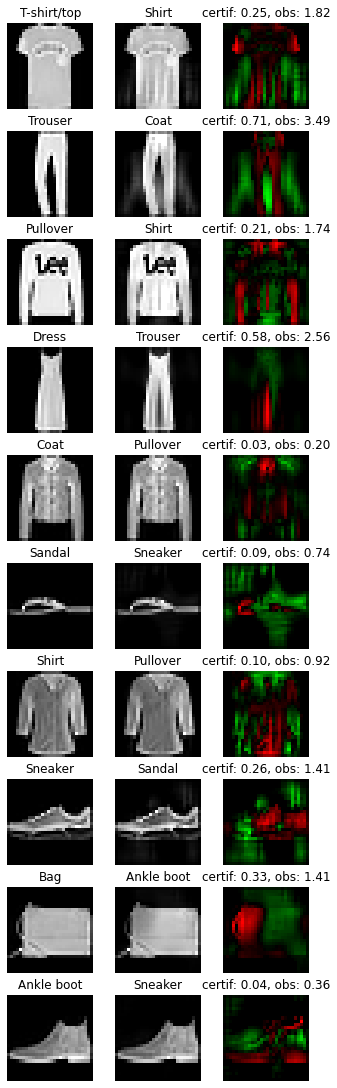

In [7]:
import matplotlib.pyplot as plt

def adversarial_viz(model, images, advs, class_names):
    """
    This functions shows for each image sample:
    - the original image
    - the adversarial image
    - the difference map
    - the certificate and the observed distance to adversarial
    """
    scale = 1.5
    nb_imgs = images.shape[0]

    # Compute certificates
    values, _ = model(images).topk(k=2)
    certificates = (values[:, 0] - values[:, 1]) / np.sqrt(2)

    # Compute distance between image and its adversarial
    dist_to_adv = (images - advs).square().sum(dim=(1, 2, 3)).sqrt()

    # Find predicted classes for images and their adversarials
    orig_classes = [class_names[i] for i in model(images).argmax(dim=-1)]
    advs_classes = [class_names[i] for i in model(advs).argmax(dim=-1)]

    # Compute difference maps
    advs = advs.detach().cpu()
    images = images.detach().cpu()
    diff_pos = np.clip(advs - images, 0, 1.0)
    diff_neg = np.clip(images - advs, 0, 1.0)
    diff_map = np.concatenate(
        [diff_neg, diff_pos, np.zeros_like(diff_neg)], axis=1
    ).transpose((0, 2, 3, 1))

    # Create plot
    def _set_ax(ax, title):
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")

    figsize = (3 * scale, nb_imgs * scale)
    _, axes = plt.subplots(
        ncols=3, nrows=nb_imgs, figsize=figsize, squeeze=False, constrained_layout=True
    )
    for i in range(nb_imgs):
        _set_ax(axes[i][0], orig_classes[i])
        axes[i][0].imshow(images[i].squeeze(), cmap="gray")
        _set_ax(axes[i][1], advs_classes[i])
        axes[i][1].imshow(advs[i].squeeze(), cmap="gray")
        _set_ax(axes[i][2], f"certif: {certificates[i]:.2f}, obs: {dist_to_adv[i]:.2f}")
        axes[i][2].imshow(diff_map[i] / diff_map[i].max())


adversarial_viz(vanilla_model, images, advs, test_set.classes)
